In [10]:
import numpy as np
import pickle
import os
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from scipy import signal
from util import *



In [11]:
def separate_concat(input_vector,field_durations, factors, phase_factor = np.pi):
    '''
    expecting intensity then phase then energy values for three fields
    '''
    if len(field_durations) != 3:
        print("not enough fields")
    intensity1 = input_vector[0:field_durations[0]]
    intensity2 = input_vector[field_durations[0]:field_durations[0]+field_durations[1]]
    intensity3 = input_vector[field_durations[0]+field_durations[1]:field_durations[0]+field_durations[1]+field_durations[2]]
    phase1 = input_vector[field_durations[0]+field_durations[1]+field_durations[2]:2*field_durations[0]+field_durations[1]+field_durations[2]]
    phase2 = input_vector[2*field_durations[0]+field_durations[1]+field_durations[2]:2*field_durations[0]+2*field_durations[1]+field_durations[2]]
    phase3 = input_vector[2*field_durations[0]+2*field_durations[1]+field_durations[2]:2*field_durations[0]+2*field_durations[1]+2*field_durations[2]]
    energy1 = input_vector[-3]
    energy2 = input_vector[-2]
    energy3 = input_vector[-1]
    

    phase1 = phase1*phase_factor
    phase2 = phase2*phase_factor
    phase3 = phase3*phase_factor

    intensity1 = intensity1/np.max(intensity1)
    field1 = np.sqrt(intensity1)*np.exp(1j*phase1)
    field1 = energy_match_expanded(field1, energy1, factors["domain_spacing_1"], factors["beam_area"] )
    
    #intensity1 = intensity1/np.sum(intensity1)*energy1
    intensity2 = intensity2/np.max(intensity2)
    field2 = np.sqrt(intensity2)*np.exp(1j*phase2)
    field2 = energy_match_expanded(field2, energy2, factors["domain_spacing_2"], factors["beam_area"] )


    #intensity2 = intensity2/np.sum(intensity2)*energy2
    intensity3 = intensity3/np.max(intensity3)
    field3 = np.sqrt(intensity3)*np.exp(1j*phase3)
    field3 = energy_match_expanded(field3, energy3, factors["domain_spacing_3"], factors["beam_area"] )

    #intensity3 = intensity3/np.sum(intensity3)*energy3
    
    return field1, field2, field3, [energy1,energy2,energy3]

def change_domains(domain, field, new_domain, domain_type):
    padded_vector = np.pad(field, (1, 1), mode='constant')
    window = signal.windows.tukey(int(len(padded_vector) // 1))
    padded_vector = window * padded_vector

    # Extend old domain to match new domain
    alt_domain = np.append([new_domain[0]], domain)
    alt_domain = np.append(alt_domain, [new_domain[-1]])

    # Resample padded vector using new domain
    resampled_vector = resample_method1(alt_domain, new_domain, padded_vector)
    

    if (domain_type == "freq"):
        out_direct = ifft(field)
        out = ifft(resampled_vector)
    elif (domain_type == "time"):
        out_direct = fft(field)
        out = fft(resampled_vector)
    else:
        print("field type not supported")

    return out_direct, out


def change_domain_and_adjust_energy(domain, field, new_domain, domain_type, beam_area, domain_spacing,
                                    true_domain_spacing):
    out_direct, out = change_domains(domain, field, new_domain, domain_type)
    domain_spacing_calc = domain[1] - domain[0]
    pulse_energy_calc = calc_energy_expanded(field, domain_spacing_calc, beam_area)
    out_direct = energy_match_expanded(out_direct, pulse_energy_calc, domain_spacing, beam_area)
    out = energy_match_expanded(out, pulse_energy_calc, true_domain_spacing, beam_area)

    print("direct, and resampled energies: ", calc_energy_expanded(out_direct, domain_spacing, beam_area),
          calc_energy_expanded(out, true_domain_spacing, beam_area))

    return out_direct, out


def change_domain_timeFreq(t):
    # Calculate time step and sample frequency
    dt = t[1] - t[0]
    fs = 1 / dt

    # Calculate frequency vector using fftfreq
    n = len(t)
    freqs = np.fft.fftfreq(n, dt)

    # Shift frequency vector so that 0 Hz is in the center
    freqs = np.fft.fftshift(freqs)

    return freqs

def intensity_phase_plot(domains, fields, labels, colors, domain_type, xlims=None, ylabel=None, normalize=False, legend=False,offsets=None,
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False):
    """
    Plot intensity and phase of a field
    """
    if domain_type == "time":
            factor = 1e12
            xlabel = "time (ps)"
    elif domain_type == "wavelength":
        factor = 1e9
        xlabel = "wavelength (nm)"
    elif domain_type == "frequency" or domain_type == "freq":
        factor = 1e-12
        xlabel = "frequency (THz)"
    for ii in range(len(domains)):
        domains[ii] = domains[ii]*factor

    intensities = [get_intensity(field) for field in fields]
    phases = [np.unwrap(get_phase(field)) for field in fields]

    

    ylabel2 = "Phase (rad)"
    #TODO: get clear working so that can call function multiple times and have all plots appear
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4),clear=False)

    axs.set_xlabel(xlabel)

    
    
    for ii in range(len(intensities)):
        if normalize:
            intensity = intensities[ii] / np.max(intensities[ii])
            ylabel1 = "Norm. Intensity (a.u.)"
        else:
            ylabel1 = "Fluence (J/m^2)"
#             warnings.warn("Using default intensity units (J/m^2)")
            intensity = intensities[ii]

        if ylabel is None:
            ylabel1 = ylabel1
        else:
            ylabel1 = ylabel
        if offsets is not None:
            offset = offsets[ii]
        axs.plot(domains[ii], intensity+offset, color=colors[ii], label=labels[ii],alpha=.6)
    if (legend):
        plt.legend()
    if xlims is not None:
        axs.set_xlim(xlims[0], xlims[1])
    axs.set_ylabel(ylabel1, color="black")
    ax2 = axs.twinx()
    for ii in range(len(intensities)):
        
        ax2.plot(domains[ii], phases[ii], color=colors[ii], linestyle="dashed",alpha=.6)

    ax2.set_ylabel(ylabel2, color="black")

    if save:
        if save_name is None:
            raise ValueError("Save name is not specified")
        if "." + save_format not in save_name:
            save_name += "." + save_format
        plt.savefig(save_name, bbox_inches='tight', dpi=300, transparent=True, format=save_format)
    if plot_show:
        plt.show()
    else:
        if ~plot_hold:
            plt.close()
def resample_method1(input_domain, target_domain, input_vector):
    try:
        f = interp1d(input_domain, input_vector)
        resampled_vector = f(target_domain)
        return resampled_vector
    except ValueError:
        print("Likely the target wavelength vector is outside the bounds of the input vector (only interpolation\n")


In [20]:
saved_model_output_dir = "/sdf/group/lcls/ds/scratch/s2e_scratch/Data/SFG_RNN_0602/model1_intPhEn" #directory from model training
data_directory = "/sdf/group/lcls/ds/scratch/s2e_scratch/Data/SFG_intPhEn/version2" #directory from preprocessing

train_losses = np.load(os.path.join(saved_model_output_dir, "train_losses.npy"))
val_losses = np.load(os.path.join(saved_model_output_dir, "val_losses.npy"))

all_preds = np.load(os.path.join(saved_model_output_dir, "all_preds_29.npy"))
all_preds_trans = np.load(os.path.join(saved_model_output_dir, "all_preds_transformed_29.npy"))

freq_vectors_shg1 = np.load(
    "../Data/shg_freq_domain_ds.npy")
freq_vectors_shg2 = freq_vectors_shg1 # these are equivalent here
freq_vectors_sfg = np.load(
    "../Data/sfg_freq_domain_ds.npy")

domain_spacing_1 = (freq_vectors_shg1[1] - freq_vectors_shg1[0]) * 1e12 #scaled to be back in Hz
domain_spacing_2 = (freq_vectors_shg2[1] - freq_vectors_shg2[0]) * 1e12
domain_spacing_3 = (freq_vectors_sfg[1] - freq_vectors_sfg[0]) * 1e12

factors_freq = {"beam_area": 400e-6 ** 2 * np.pi,
                "grid_spacing": [domain_spacing_1, domain_spacing_2, domain_spacing_3],
                "domain_spacing_1": domain_spacing_1, "domain_spacing_2": domain_spacing_2,
                "domain_spacing_3": domain_spacing_3} #beam radius 400 um (and circular beam)
                          
                          
y_90 = np.load(os.path.join(data_directory, "y_new_90.npy")) #these are used to compare to the predictions


with open(os.path.join(data_directory, 'scaler.pkl'), 'rb') as file: #can use scaler.pkl or scaler_bckkup.pkl
    scaler = pickle.load(file)
               
y_90_trans  = scaler.inverse_transform(y_90)

sfg_original_freq= np.load("../Data/sfg_original_freq_vector.npy")
sfg_original_time= np.load("../Data/sfg_original_time_vector.npy")
sfg_original_time_ds = sfg_original_time[1]-sfg_original_time[0]


/opt/conda/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [22]:
ii = 8 #use this to select one of the examples (should be 100 in total to choose among)

y_pred_trans = all_preds_trans[ii]
y_true_trans = y_90_trans[99:][::100][ii]

y_pred_trans_shg1, y_pred_trans_shg2, y_pred_trans_sfg, y_energies_pred = separate_concat(y_pred_trans,field_durations=[1892, 1892, 348], factors=factors_freq)
y_true_trans_shg1, y_true_trans_shg2, y_true_trans_sfg, y_energies_true = separate_concat(y_true_trans,field_durations=[1892, 1892, 348], factors=factors_freq)


sfg_freq_to_time_direct_pred, sfg_freq_to_time_pred=change_domain_and_adjust_energy(freq_vectors_sfg, y_pred_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)
sfg_freq_to_time_direct_true, sfg_freq_to_time_true=change_domain_and_adjust_energy(freq_vectors_sfg, y_true_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)


shg1_freq_to_time_direct_pred, shg1_freq_to_time_pred=change_domain_and_adjust_energy(freq_vectors_shg1, y_pred_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)
shg1_freq_to_time_direct_true, shg1_freq_to_time_true=change_domain_and_adjust_energy(freq_vectors_shg1, y_true_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)

shg2_freq_to_time_direct_pred, shg2_freq_to_time_pred=change_domain_and_adjust_energy(freq_vectors_shg2, y_pred_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)
shg2_freq_to_time_direct_true, shg2_freq_to_time_true=change_domain_and_adjust_energy(freq_vectors_shg2, y_true_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)




direct, and resampled energies:  3.38371655593889e-10 3.3837165559388913e-10
direct, and resampled energies:  2.0730994566781724e-09 2.0730994566781732e-09
direct, and resampled energies:  2.499983253021596e-05 2.4999832530215965e-05
direct, and resampled energies:  2.4998963040270783e-05 2.4998963040270787e-05
direct, and resampled energies:  2.4999835007395282e-05 2.499983500739529e-05
direct, and resampled energies:  2.4998965517450117e-05 2.4998965517450117e-05


In [23]:
print(y_energies_true)
print(y_energies_pred)

[24998963.040270787, 24998965.517450117, 2073.0994566781733]
[24999832.0, 24999832.0, 338.37164]


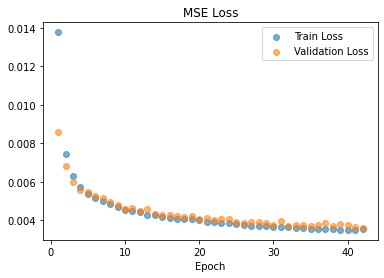

In [24]:
#training and validation error
plt.scatter(range(1, train_losses.shape[0]+1, 1), train_losses, label="Train Loss", alpha=0.6)
plt.scatter(range(1, val_losses.shape[0]+1, 1), val_losses, label="Validation Loss", alpha=0.6)
plt.title("MSE Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

------- Normalized True vs Prediction Frequency Domain --------
*** SFG ***


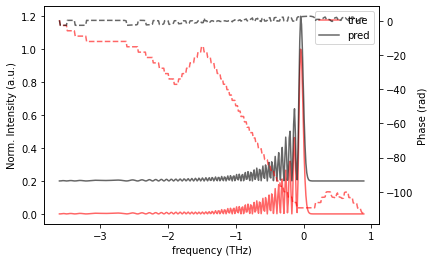

*** SHG1 ***


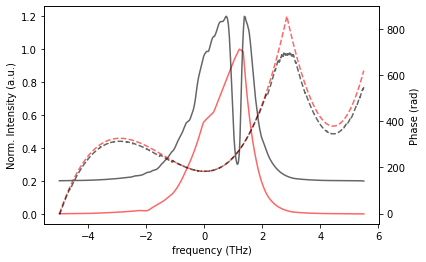

*** SHG2 ***


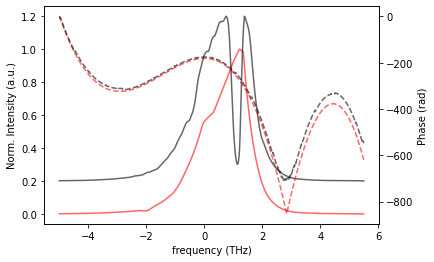

------- Non-normalized True vs Prediction Frequency Domain --------
*** SFG ***


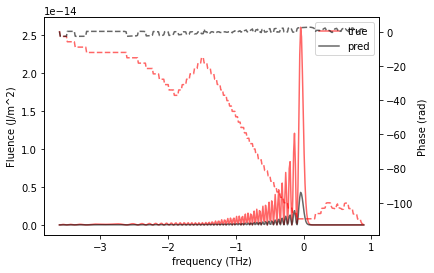

*** SHG1 ***


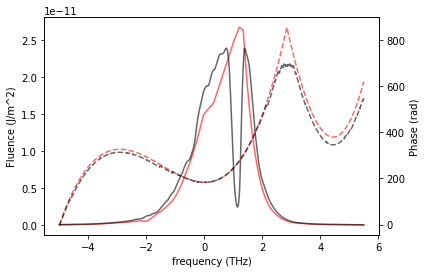

*** SHG2 ***


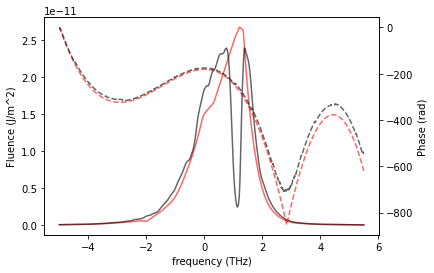

------- Normalized True vs Prediction Time Domain --------
*** SFG ***


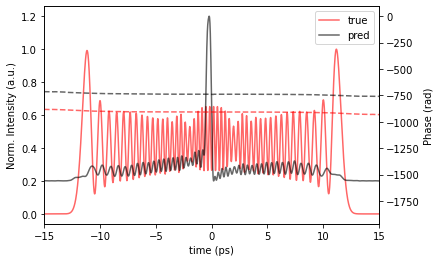

*** SHG1 ***


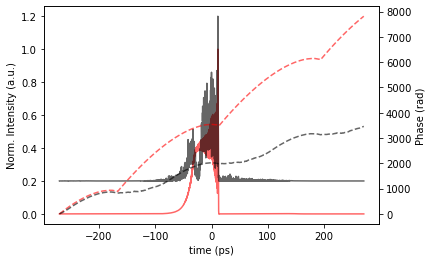

*** SHG2 ***


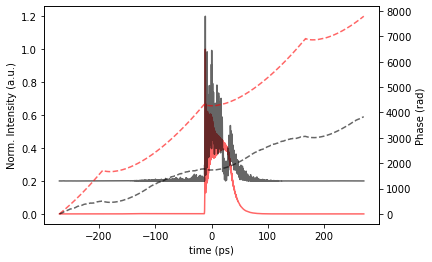

------- Non-normalized True vs Prediction Frequency Domain --------
*** SFG ***


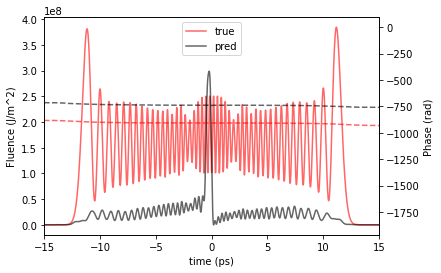

*** SHG1 ***


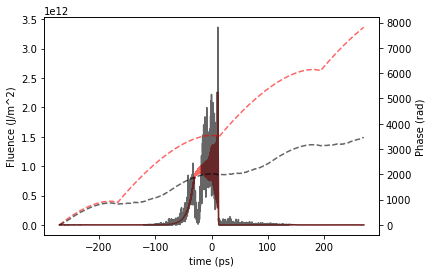

*** SHG2 ***


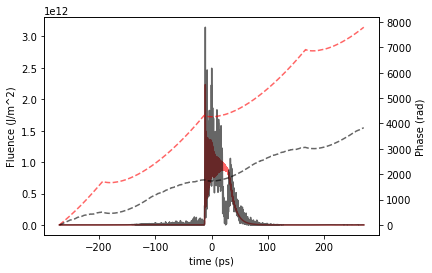

In [25]:
#plots frequency domain for all three fields (prediction vs true) normalized (first three) and non-normalized (next three)
print("------- Normalized True vs Prediction Frequency Domain --------")
print("*** SFG ***")

intensity_phase_plot([freq_vectors_sfg,freq_vectors_sfg], [y_true_trans_sfg,y_pred_trans_sfg], ["true","pred"], ["red","black"], "freq", normalize=True, legend=True,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1,freq_vectors_shg1], [y_true_trans_shg1,y_pred_trans_shg1], ["true","pred"], ["red","black"], "freq", normalize=True, legend=False,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2,freq_vectors_shg2], [y_true_trans_shg2,y_pred_trans_shg2], ["true","pred"], ["red","black"], "freq", normalize=True, legend=False,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("------- Non-normalized True vs Prediction Frequency Domain --------")
print("*** SFG ***")
intensity_phase_plot([freq_vectors_sfg,freq_vectors_sfg], [y_true_trans_sfg,y_pred_trans_sfg], ["true","pred"], ["red","black"], "freq", normalize=False, legend=True,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1,freq_vectors_shg1], [y_true_trans_shg1,y_pred_trans_shg1], ["true","pred"], ["red","black"], "freq", normalize=False, legend=False,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2,freq_vectors_shg2], [y_true_trans_shg2,y_pred_trans_shg2], ["true","pred"], ["red","black"], "freq", normalize=False, legend=False,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)


#plots time domain for all three fields (prediction vs true) normalized (first three) and non-normalized (next three)
print("------- Normalized True vs Prediction Time Domain --------")
print("*** SFG ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [sfg_freq_to_time_true,sfg_freq_to_time_pred], ["true","pred"], ["red","black"], "time", xlims=[-15,15], normalize=True, legend=True,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [shg1_freq_to_time_true,shg1_freq_to_time_pred], ["true","pred"], ["red","black"], "time", normalize=True, legend=False,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [shg2_freq_to_time_true,shg2_freq_to_time_pred], ["true","pred"], ["red","black"], "time", normalize=True, legend=False,offsets=[0,.2],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("------- Non-normalized True vs Prediction Frequency Domain --------")
print("*** SFG ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [sfg_freq_to_time_true,sfg_freq_to_time_pred], ["true","pred"], ["red","black"], "time", xlims=[-15,15], normalize=False, legend=True,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [shg1_freq_to_time_true,shg1_freq_to_time_pred], ["true","pred"], ["red","black"], "time", normalize=False, legend=False,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time,sfg_original_time], [shg2_freq_to_time_true,shg2_freq_to_time_pred], ["true","pred"], ["red","black"], "time", normalize=False, legend=False,offsets=[0,0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)



